#  Quantum Phase Estimation

Given a unitary operator $U$ and an eigenstate $|\psi \rangle$, with $U|\psi \rangle = e^{i2\pi \theta}|\psi \rangle$, Quantum Phase Estimation (QPE) is an algorithm that enables us to estimate the specific value of $\theta$. 

This comes with the caveat of having to feed the original value of $\theta$ at the beginning in this demonstration. Nevertheless, this procedure turns out to be quite useful for other algorithms such as the Shor's algorithm, in which QPE is used without an original phase value.

The circuit employed in this algorithm consists of a main register made up of $n$ qubits initialized in the state $H^{n}|00..0\rangle$ and an ancilla which is initialized in the eigenstate of $U$ associated with the phase we are interested in. Note that for the unitary $U_1(\theta) = diag(1,e^{i \theta})$, this amounts to only setting the ancilla to the excited state.

The algorithm can then be broken down in two main parts. In the first one, each qubit in the main register acts on the ancilla with a controlled rotation, with a total of $n$ rotations. The idea is that each one of this rotations will correspond to a different power of $U_1(\theta)$, namely $U_1^{2^{j}}(\theta)$, where $j \in [0,n-1]$. Given that $U_1(\theta)$ is diagonal, its powers correspond to single rotations as $U_1^{2^{j}}(\theta) = U_1(2^{j}\theta)$. Hence, there is no need apply the operator $2^{j}$ times. The rotations are controlled in increasing order of $j$ throughout the main register. (*This is performed from bottom to top in order to follow the ordering convention in Qiskit*). By virtue of phase kickback, the state of each qubit in the main register is imprinted with a phase proportional to $\theta$, yielding a state of the form 

\begin{align}
\frac{1}{2^{\frac{n}{2}}} (|0 \rangle + e^{i2\pi (2^{n-1}\theta)}|1 \rangle)(|0 \rangle + e^{i2\pi (2^{n-2}\theta)}|1 \rangle) \cdots (|0 \rangle + e^{i2\pi (2^{0}\theta)}|1 \rangle) |\psi \rangle = \frac{1}{2^{\frac{n}{2}}} \sum_{k=0}^{2^{n}-1} e^{i2\pi k \theta} |k \rangle|\psi \rangle,
\end{align}

where $k$ is the integer representation of the qubits in the main register. The second part corresponds to applying an inverse quantum Fourier transform ($QFT^{\dagger}$) to the qubits in the main register, resulting in 

\begin{equation}
\frac{1}{2^{\frac{n}{2}}} \sum_{k=0}^{2^{n}-1} e^{i2\pi k \theta} (QFT^{\dagger}|k \rangle)|\psi \rangle = 
\frac{1}{2^{n}} \sum_{x} \sum_{k} e^{-\frac{i2\pi k}{2^{n}}(x-2^{n}\theta)} |x \rangle|\psi \rangle . 
\end{equation}

We note that in this state the probability has a peak around $x = 2^{n} \theta $. Then, by measuring the qubits in the main register, we will obtain the state $|x \approx 2^{n} \theta \rangle|\psi \rangle$ with high probability. By transforming this number back to an integer and diving by a factor of $2^{n}$ we retrieve the phase $\theta$. 

Finally, if $2^{n} \theta$ is an integer we expect to measure exactly $|x = 2^{n} \theta \rangle$ with high probability. If this is not the case, then the most frequent outcomes will correspond to values close to  $2^{n} \theta$. Note that this implies that the bigger the main register is, the more precise the resulting value of $\theta$ will be, as we show below.


Refs.:

[1] Further details can be found in Qiskit tutorial notes: https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html

[2] Nielsen and Chuang - *Quantum computation and quantum information*

In [100]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

import numpy as np
pi = np.pi

%matplotlib inline 
from matplotlib import pyplot as plt

In [2]:
# Load personal IBM account
IBMQ.load_account() 

/opt/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

### Definitions of Quantum Fourier Transform and inverse 

In [3]:
def qft_rot(circuit,nq):
    ''' First part of the Quantum Fourier Transform. This function performs rotations 
    on a specific target qubit, which are controlled by remaining qubits that have not 
    been rotated yet. This is therefore performed recursively in order to progressively 
    reduce the number of qubits affected by the operation. The particular order of operation 
    has been set such that it follows the notation order in Qiskit. The target qubit is 
    thus the last one in the circuit and the function recursively moves upwards.'''

    # If all qubits have been acted on return the circuit
    if nq == 0:        
        return circuit
    
    # Reduce by one the number of qubits in order to recursevely move through the circuit
    nq-=1
    
    # Act with a Hadamard gate on the target qubit
    circuit.h(nq)
    
    # Controlled rotations on the target qubit, with each one of the remaining qubits as controls
    for q in range(nq):
    
        circuit.cu1(2*pi/2**(nq+1-q),q,nq)
    
    # Recursively call the function to cover the entire circuit
    return qft_rot(circuit,nq)




def qft_swaps(circuit,nq):
    '''Second part of the Quantum Fourier transform. This function swaps qubits 
    paired from top and bottom towards the middle.'''
       
    # Swapping of each pair
    for q in range(nq//2):       
        circuit.swap(q,nq-1-q)
        
    return circuit



def qft(circuit,nq):
    '''Quantum Fourier Transform. The function is split into a series of controlled 
    rotations and swap operations. See Qiskit textbook section about QFT for details.'''
    
    # Rotations on the qubits
    circuit = qft_rot(circuit,nq)
    circuit.barrier()
    
    # Qubit swaps
    circuit = qft_swaps(circuit,nq)
    
    return circuit

In [4]:
def inv_qft(circuit,nq):
    ''' Inverse Quantum Fourier Transform. The function first generates a Fourier transformed
    circuit. Next, exploiting the unitarity of the QFT, inverts the circuit using the .inverse()
    method. This inverted circuit is then appended to the original one.'''
    
    # Generate a circuit of size nq and apply a QFT to it
    circuit_qft = qft(QuantumCircuit(nq),nq)
    
    # Invert the transformed circuit and append it to the original one
    circuit += circuit_qft.inverse()
    
    return circuit

## Encoding by phase kickback

In [87]:
def phase_encoding(circuit,nq,th):
    ''' This function applies nqubits-1 rotations on the ancilla qubit controlled by each
    one of the qubits in the main register. This encodes the phase on the states via phase 
    kickback on the qubits that act as controlls.'''
    
    # Number of qubits in the main register
    n = nq-1
    
    # Perform rotations of decreasing angle
    for q in range(n):
        circuit.cu1(th*2**(n-1-q),n-1-q,n)
        
    return circuit
    

## Quantum phase estimation

In [88]:
def Quantum_Phase_Estimation_Circuit(nq,th):
    '''This function returns a circuit that performs Quantum Phase Estimation of 
    an angle 'th' using 'nq' qubits.'''

    qr = QuantumRegister(nq)
    cr = ClassicalRegister(nq-1)

    qpe_circ = QuantumCircuit(qr,cr)

    # Initialize qubit in main register acting with Hadamard gate
    for qubit in range(nq-1):
        qpe_circ.h(qubit)
    
    # Initialize ancilla state in the excited state
    qpe_circ.x(nq-1)
    qpe_circ.barrier()

    # Encode the phase from ancilla in the main register
    qpe_circ = phase_encoding(qpe_circ,nq,th)

    # Apply inverse QFT on the main register
    qft_inverse_circ = inv_qft(QuantumCircuit(nq-1),nq-1)
    qft_inverse_circ.name = '$\ QFT^{\dagger}$'
    qpe_circ.append(qft_inverse_circ, qpe_circ.qubits[:(nq-1)])
    qpe_circ.barrier()

    # Measure all qubits in the main register
    for qubit in range(nq-1):
        qpe_circ.measure(qubit,qubit)
        
        
    return qpe_circ
    

### Classical simulation

We start with a case in which the factor $2^{n}\theta$ is an integer.

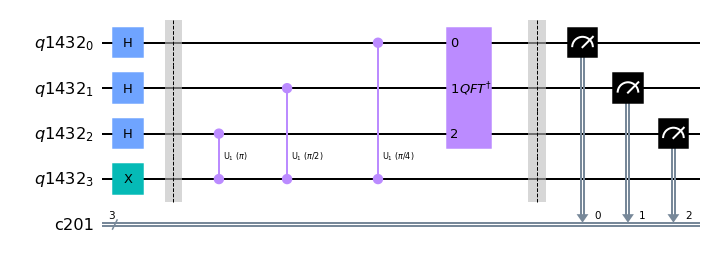

In [131]:
th = 1/8 # Phase we want to encode 
angle = 2*pi*th
nqubits = 4 # Number of qubits in the system

circ = Quantum_Phase_Estimation_Circuit(nqubits,angle)

circ.draw(output='mpl')

In [132]:
sim = Aer.get_backend('qasm_simulator')
qpe_result = execute(circ, backend = sim, shots = 4096).result()

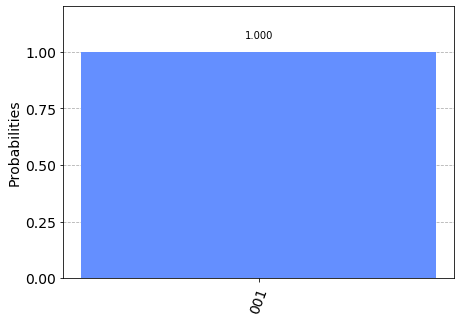

In [133]:
plot_histogram(qpe_result.get_counts())

As predicted, we only measure the state $|2^{n} \theta \rangle = |001 \rangle$ as $2^{n} \theta$ is an integer. Switching to integer '001'=1 and dividing by $2^{n}$, we obtain $\theta = 1/8$.

We now try we a different value in which $2^{n} \theta$ is not an integer.

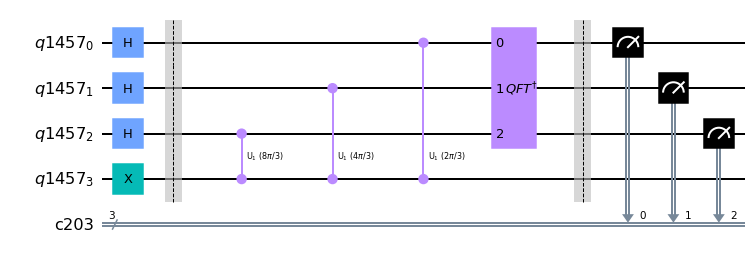

In [140]:
th = 1/3 # Phase we want to encode 
angle = 2*pi*th
nqubits = 4 # Number of qubits in the system

circ = Quantum_Phase_Estimation_Circuit(nqubits,angle)

circ.draw(output='mpl')

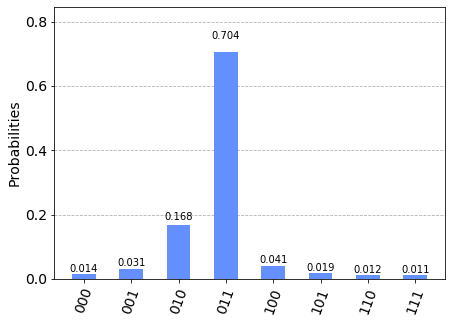

In [142]:
sim = Aer.get_backend('qasm_simulator')
qpe_result = execute(circ, backend = sim, shots = 4096).result()

plot_histogram(qpe_result.get_counts())

As expected, we do not obtain a single result now. Let's see what value of $\theta$ yields the most frequently measured state.

In [143]:
# Retrieve most frequently measured state
qpe_mf = qpe_result.get_counts().most_frequent()

# Using the state to retrieve theta
theta = int(qpe_mf,2)/2**(nqubits-1)

print(theta)

0.375


The value we expect is $\theta = 0.333 $... . While $0.375$ might be a close guess, we now show that by increasing the size of the main register we can obtain increasingly more accurate values of $\theta$.

Text(0, 0.5, '$\\theta_{estimate}$')

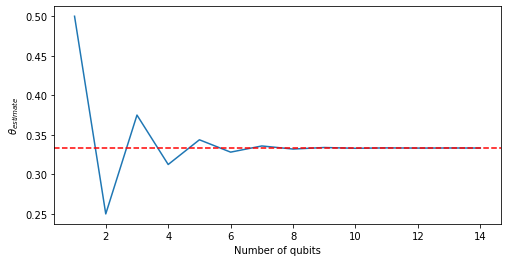

In [147]:
th = 1/3 # Phase we want to encode 
angle = 2*pi*th

phases = [] # List of estimated phases

nqubits = list(range(1,15)) # Number of qubits in the main register

sim = Aer.get_backend('qasm_simulator')

# Repeat the simulation for increasing size of main register
for n in nqubits:
    
    # Deifine and execute circuit
    circ = Quantum_Phase_Estimation_Circuit(n+1,angle)
    qpe_result = execute(circ, backend = sim, shots = 4096).result()
    
    # Extrapolate value of theta from most frequently measured state
    qpe_mf = qpe_result.get_counts().most_frequent()
    
    # Add to the phases list the measured value 
    phases.append(int(qpe_mf,2)/2**(n))
    

# Plot the results and the real value in a horizontal line
fig = plt.figure(figsize=(8, 4), frameon=False)

plt.plot(nqubits,phases)
plt.axhline(y=angle/(2*pi), color='r', linestyle='--')

plt.xlabel('Number of qubits')
plt.ylabel(r'$\theta_{estimate}$')
    

We find that indeed for a larger number of qubits in the main register, the measured value of $\theta$ becomes more and more accurate. For registers of size $n>11$ the error is already very small.

### Quantum Simulation

Finally, we test our code in a real device. Given their current limited size, we only look at the simple case of $2^{n} \theta$ integer discussed above.

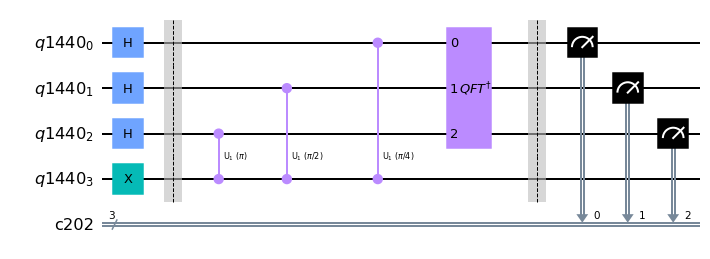

In [134]:
th = 1/8 # Phase we want to encode 
angle = 2*pi*th
nqubits = 4 # Number of qubits in the system

circ = Quantum_Phase_Estimation_Circuit(nqubits,angle)

circ.draw(output='mpl')

In [137]:
provider = IBMQ.get_provider(hub = 'ibm-q')
simQ = provider.get_backend('ibmq_athens')

qpe_job = execute(circ, backend = simQ, shots = 4096)

print(qpe_job.job_id())
job_monitor(qpe_job)

600dcf8c92599a89cbb1922f
Job Status: job has successfully run


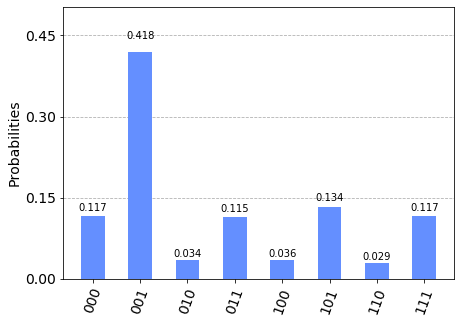

In [138]:
qpe_result = qpe_job.result()

plot_histogram(qpe_result.get_counts())

As opposed as before, '001' is not the only measured state, although it is the most frequently measured, as expected. This difference stems from physical errors in the device while performing gate operations and external noise.